# HuBMAP - Efficient Sampling Ensemble (deepflash2, pytorch, fastai) [train]

> Kernel for model training with efficient region based sampling.

Requires deepflash2 (git version), zarr, and segmentation-models-pytorch


## Overview

1. Installation and package loading
2. Helper functions and patches
3. Configuration
4. Training

### Inputs
- https://www.kaggle.com/matjes/hubmap-zarr converted images (downscaled with factor 2)
- https://www.kaggle.com/matjes/hubmap-labels-pdf-0-5-0-25-0-01 masks and weights for sampling

### Versions
- V7: Fixed augmentations in deepflash2 `RandomTileDataset` config (random zoom) - LB 0.913
- V8: Adding *albumentations* transforms, switching to Cross-entropy loss

## Motivation

### Background

A glomerulus is a network of small blood vessels located at the beginning of a nephron in the kidney ([Wikipedia](https://en.wikipedia.org/wiki/Glomerulus_(kidney))
)). Glomeruli are mainly found in the renal **cortex**, while the renal **medulla** contains mainly the renal tubule. Since we are dealing with biological structures, the separation is not not absolute and the transitions are not always perfectly sharp.

![Diagram of a nephron](http://s3-us-west-2.amazonaws.com/courses-images/wp-content/uploads/sites/1842/2017/05/26234530/m9skcbftjqzrokkkopam.png)
[Diagram of a nephron from libretexts.org, Introductory and General Biology](https://bio.libretexts.org/Bookshelves/Introductory_and_General_Biology/Book%3A_General_Biology_(Boundless)/41%3A_Osmotic_Regulation_and_the_Excretory_System/41.4%3A_Human_Osmoregulatory_and_Excretory_Systems/41.4B%3A_Nephron%3A_The_Functional_Unit_of_the_Kidney)

### Key Idea

A common approach to deal with the very large (>500MB - 5GB) TIFF files in the dataset is to decompose the images in smaller patches/tiles, for instance by using a sliding window apporach.
> **Knowing that the glomeruli are mainly found in the cortex, we should focus on this region during training**. 

Instead of preprocessing the images and saving them into fixed tiles, we sample tiles from the entire images with a higher probability on tiles that contain glumeroli and cortex. Have a look at [this kernel](https://www.kaggle.com/matjes/hubmap-labels-pdf-0-5-0-25-0-01) for more details.


## Advantages of this approach

In combination with [deepflash2](https://github.com/matjesg/deepflash2/tree/master/) and the deepflash2 [pytorch datasets](https://matjesg.github.io/deepflash2/data.html#Datasets) in particular, this approach has several advantages:
- no preprocessing of the data (only saving them to .zarr files for memory efficient loading)
    - flexible tile shapes (input shapes, e.g. 1024, 512, 256) at runtime
    - flexible scaling (e.g., by facors of 2,3,4)
- faster convergence during traing (~30 min for training a competitive model)
    - focusing on the relevant regions (e.g., tiles that contain glumeroli and cortex)
    - "additional" data augmentation from random sampling (compared to fixed windows)

### Installation and package loading

In [1]:
!pip install -q input/deepflash2-lfs
!git clone https://github.com/qubvel/segmentation_models.pytorch.git
!pip install -q ./segmentation_models.pytorch
!pip install git+https://github.com/p-sodmann/Augmedical

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
fatal: destination path 'segmentation_models.pytorch' already exists and is not an empty directory.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


  Cloning https://github.com/p-sodmann/Augmedical to c:\users\soodn\appdata\local\temp\pip-req-build-0ao6iu87
  Resolved https://github.com/p-sodmann/Augmedical to commit 2c1231f6f2a9dafaa0233bcdafd4b8c81693c75c


  Running command git clone -q https://github.com/p-sodmann/Augmedical 'C:\Users\soodn\AppData\Local\Temp\pip-req-build-0ao6iu87'


In [2]:
# imports
import torch
import zarr, cv2, random
import numpy as np, pandas as pd
import segmentation_models_pytorch as smp
from fastai.vision.all import *
from deepflash2.all import *
from scipy import interpolate
from torch.utils.data import Dataset
from sklearn.model_selection import KFold
from hubmap_loss_metrics import *
from augmedical.transforms.transforms import ImageTransform
from augmedical.colors.colors import Deconvolution
from tqdm.auto import tqdm
import albumentations as A

In [3]:
import wandb

wandb.login(key="6883cb3173ae477ba8d8bde16206f1eaa23dc106")
from fastai.callback.wandb import *

wandb: Currently logged in as: soodn (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\soodn/.netrc


## Helper functions and patches

In [4]:
# Patch for deepflash2 'DeformationField' class, see https://fastcore.fast.ai/basics.html#patch
@patch
def apply(self:DeformationField, data, offset=(0, 0), pad=(0, 0), order=1):
    "Apply deformation field to image using interpolation"
    outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
    coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
    # Get slices to avoid loading all data (.zarr files)
    sl = []
    for i in range(len(coords)):
        cmin, cmax = int(coords[i].min()), int(coords[i].max())
        dmax = data.shape[i]
        if cmin<0: 
            cmax = max(-cmin, cmax)
            cmin = 0 
        elif cmax>dmax:
            cmin = min(cmin, 2*dmax-cmax)
            cmax = dmax
            coords[i] -= cmin
        else: coords[i] -= cmin
        sl.append(slice(cmin, cmax))    
    if len(data.shape) == len(self.shape) + 1:
        tile = np.empty((*outshape, data.shape[-1]))
        for c in range(data.shape[-1]):
            # Adding divide
            tile[..., c] = cv2.remap(data[sl[0],sl[1], c]/255, coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    else:
        tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    return tile

In [15]:
from random import shuffle

class HubmapRandomTileDataset(Dataset):
    """
    Pytorch Dataset that creates random tiles with augmentations from the input images.
    """
    n_inp = 1
    def __init__(self, 
                 files,
                 label_path,
                 cdf_path, 
                 df_stats, 
                 sample_multiplier=50,
                 tile_shape = (512,512),
                 scale = 1,
                 flip = True,                                
                 rotation_range_deg = (0, 360),     
                 deformation_grid = (150,150), 
                 deformation_magnitude = (10,10),
                 value_minimum_range = (0, 0), 
                 value_maximum_range = (1, 1), 
                 value_slope_range = (1, 1),
                 albumentations_tfms=None,
                 augmedical_transforms=None,
                 deconv=True,
                 **kwargs
                ):
        store_attr('files, df_stats, sample_multiplier, tile_shape, scale, albumentations_tfms')
        store_attr('flip, rotation_range_deg, deformation_grid, deformation_magnitude, value_minimum_range, value_maximum_range, value_slope_range')
        
        self.data = zarr.open_group(self.files[0].parent.as_posix(), mode='r')
        self.labels = zarr.open_group(label_path)
        self.cdfs = zarr.open_group(cdf_path)
        
        self.indices = []
        self.center_indices = []
        self.df_stats = self.df_stats[self.df_stats.index.isin([f.stem for f in self.files],  level=0)]
        print('Preparing sampling')
        for key, grp in self.df_stats.groupby('idx'):
            for (idx, i), row in grp.iterrows():
                self.indices.append(idx)
                self.center_indices.append(i)
            for _ in range(self.sample_multiplier):
                self.indices.append(idx)
                self.center_indices.append(None)         
        self.on_epoch_end()
        
        # briefly disable transformations to calc stats
        self.albumentations_tfms = None   
        self.augmedical_transforms = None
        self.deconv = False
        
        if deconv:
            print('Calculating stats for stain normalization w/o albumentation tfms')
            self.dkv_stats = {}
            self.dkv = Deconvolution()
            for f in progress_bar(self.files):
                idxs = [i for i, x in enumerate(self.indices) if x==f.stem]
                t = []
                for i in tqdm(idxs[:100], leave=False):
                    t.append(self[i][0].numpy().transpose(1,2,0))
                
                self.dkv_stats[f.stem] = self.dkv.fit(t)
                
            self.deconv = True
        
            print(self.dkv_stats)
        
        self.albumentations_tfms = albumentations_tfms   
        self.augmedical_transforms = augmedical_transforms
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx): idx = idx.tolist()       
        file_name = self.indices[idx]
        center_idx = self.center_indices[idx]

        img = self.data[file_name]
        n_channels = img.shape[-1]

        lbl = self.labels[file_name]
        cdf = self.cdfs[file_name]

        center = self.random_center(cdf[:], lbl.shape, scale=512, file=file_name, center_idx=center_idx)
        X = self.gammaFcn(self.deformationField.apply(img, center).flatten()).reshape((*self.tile_shape, n_channels))
        Y = self.deformationField.apply(lbl, center, (0,0), 0)

        if self.albumentations_tfms:
            augmented = self.albumentations_tfms(image=(X*255).astype('uint8'),mask=Y.astype('uint8'))
            X = (augmented['image']/255)
            Y = augmented['mask']
            
        if self.deconv:
            d_mean,  d_std = self.dkv_stats[file_name]
            X = self.dkv.apply(X, d_mean, 2*d_std)
            X = np.clip(X, a_min=-5, a_max=5)
            
        X = X.transpose(2, 0, 1).astype('float32')
        Y = Y.astype('int64')
        
        X = TensorImage(X)
        
        if self.augmedical_transforms:
            for transform in self.augmedical_transforms:
                X = transform(X)
        
        return  X, TensorMask(Y)
        
    def random_center(self, cdf, orig_shape, file, center_idx, scale=512):
        'Sample random center'
        if center_idx:
            stats = self.df_stats.loc[file, center_idx]
            cx = random.randrange(stats.top, stats.top+stats.height)
            cy = random.randrange(stats.left, stats.left+stats.width)
        else:
            scale_y = int((orig_shape[1]/orig_shape[0])*scale)
            # print (len(cdf), np.argmax(cdf > np.random.random()), scale, scale_y)
            cx, cy, cz= np.unravel_index(np.argmax(cdf > np.random.random()), (scale,scale_y, 3))
            cx = int(cx*orig_shape[0]/scale)
            cy = int(cy*orig_shape[1]/scale_y)
        return cx, cy
        
    def on_epoch_end(self, verbose=True):

        if verbose: print("Generating deformation field")
        self.deformationField = DeformationField(self.tile_shape, self.scale)

        if self.rotation_range_deg[1] > self.rotation_range_deg[0]:
            self.deformationField.rotate(
                theta=np.pi * (np.random.random()
                            * (self.rotation_range_deg[1] - self.rotation_range_deg[0])
                            + self.rotation_range_deg[0])
                            / 180.0)

        if self.flip:
            self.deformationField.mirror(np.random.choice((True,False),2))

        if self.deformation_grid is not None:
            self.deformationField.addRandomDeformation(
                self.deformation_grid, self.deformation_magnitude)

        if verbose: print("Generating value augmentation function")
        minValue = (self.value_minimum_range[0]
            + (self.value_minimum_range[1] - self.value_minimum_range[0])
            * np.random.random())

        maxValue = (self.value_maximum_range[0]
            + (self.value_maximum_range[1] - self.value_maximum_range[0])
            * np.random.random())

        intermediateValue = 0.5 * (
            self.value_slope_range[0]
            + (self.value_slope_range[1] - self.value_slope_range[0])
            * np.random.random())

        self.gammaFcn = interpolate.interp1d([0, 0.5, 1.0], [minValue, intermediateValue, maxValue], kind="quadratic")  
        

In [16]:
class HubmapValidationDataset(Dataset):
    "Pytorch Dataset that creates random tiles for validation and prediction on new data."
    n_inp = 1
    def __init__(self, 
                 files, 
                 label_path, 
                 tile_shape = (512,512),
                 scale=1,
                 val_length=None, 
                 val_seed=42, 
                 deconv=True,
                 **kwargs
                ):
        store_attr('files, label_path, tile_shape, scale, val_seed')
        self.data = zarr.open_group(self.files[0].parent.as_posix())
        self.labels = zarr.open_group(label_path)
        self.output_shape = self.tile_shape
        self.tiler = DeformationField(self.tile_shape, scale=self.scale)
        self.image_indices = []
        self.image_shapes = []
        self.centers = []
        self.valid_indices = None

        j = 0
        self.deconv = False
        if deconv: 
            self.dkv = Deconvolution()
            self.dkv_stats = {}
            
        for i, file in enumerate(progress_bar(self.files, leave=False)):
            img = self.data[file.name]
            
            # Tiling
            data_shape = tuple(int(x//self.scale) for x in img.shape[:-1])
            start_points = [o//2 for o in self.output_shape]
            end_points = [(s - st) for s, st in zip(data_shape, start_points)]
            n_points = [int((s)//(o))+1 for s, o in zip(data_shape, self.output_shape)]
            center_points = [np.linspace(st, e, num=n, endpoint=True, dtype=np.int64) for st, e, n in zip(start_points, end_points, n_points)]
            # temp variable for deconv calculation
            image_centers = []
            for cx in center_points[1]:
                for cy in center_points[0]:
                    self.centers.append((int(cy*self.scale), int(cx*self.scale)))
                    image_centers.append((int(cy*self.scale), int(cx*self.scale)))
                    self.image_indices.append(i)
                    self.image_shapes.append(data_shape)
                    j += 1
            
            # Augmedical TFMS
            if deconv:
                count = 0
                t = []
                shuffle(image_centers)
                for center in tqdm(image_centers, leave=False):
                    t.append(self.tiler.apply(img, center))
                
                self.dkv_stats[file.stem] = self.dkv.fit(t)
        
        if deconv: 
            self.deconv = True
            print(self.dkv_stats)
        
        if val_length:
            if val_length>len(self.image_shapes):
                print(f'Reducing validation from lenght {val_length} to {len(self.image_shapes)}')
                val_length = len(self.image_shapes)
            np.random.seed(self.val_seed)
            choice = np.random.choice(len(self.image_indices), val_length, replace=False)
            self.valid_indices = {i:idx for i, idx in  enumerate(choice)}

    def __len__(self):
        if self.valid_indices: return len(self.valid_indices)
        else: return len(self.image_shapes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.valid_indices: idx = self.valid_indices[idx]
        img_path = self.files[self.image_indices[idx]]
        img = self.data[img_path.name]
        centerPos = self.centers[idx]
        X = self.tiler.apply(img, centerPos)
        
        if self.deconv:
            d_mean,  d_std = self.dkv_stats[img_path.name]
            X = self.dkv.apply(X, d_mean, 2*d_std)
            X = np.clip(X, a_min=-5, a_max=5)
            
        X = X.transpose(2, 0, 1).astype('float32')
        
        lbl = self.labels[img_path.name]
        Y = self.tiler.apply(lbl, centerPos, (0,0), order=0).astype('int64')
        
        return  TensorImage(X), TensorMask(Y)   

In [17]:
def show_batch(batch):
    fig, axs = plt.subplots(4,4, figsize=(20,20))   
    images = batch[0].cpu().numpy()
    labels = batch[1].cpu().numpy()

    for i in range(16):     
        axs[i%4, i//4].imshow(images[i, 1])
        axs[i%4, i//4].imshow(labels[i], alpha=0.5)
    plt.show()
    
    plt.hist(batch[0][:,0].cpu().numpy().flatten(), bins=100, alpha=0.5)
    plt.hist(batch[0][:,1].cpu().numpy().flatten(), bins=100, alpha=0.5)
    plt.hist(batch[0][:,2].cpu().numpy().flatten(), bins=100, alpha=0.5)
    plt.show()
    


Loss

In [18]:
dc = TorchLoss(smp.losses.DiceLoss(mode='multiclass', classes=[1]))
ce = CrossEntropyLossFlat(axis=1) #TorchLoss(smp.losses.SoftCrossEntropyLoss(smooth_factor=0.))

### Config

In [19]:
# from augmentation import Desaturation, GaussianBlur, ChannelBleaching, StainShift

class CONFIG():
    # paths
    path = Path(r'C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\hubmap_colon_data\Colon_data_reprocessed\Colon_data_reprocessed')
    data_path = Path('images_scale2')
    annotations_path = Path('masks_scale2')
    
    # deepflash2 dataset
    scale = 1.5 # data is already downscaled to 2, so absulute downscale is 3
    tile_shape = (512, 512)
    sample_multiplier = 100 # Sample 100 tiles from each image, per epoch
    val_length = 500 # Randomly sample 500 validation tiles
    stats = np.array([0, 0 , 0]), np.array([1 , 1, 1])
        
    # pytorch model (segmentation_models_pytorch)
    encoder_name = "efficientnet-b2"
    encoder_weights = 'imagenet'
    in_channels = 3
    classes = 2
    
    # Training
    n_splits = 5
    mixed_precision_training = True
    batch_size = 16
    weight_decay = 0.00
    loss_func = JointLoss(dc, ce, 1, 1)
    metrics = [Dice(), Iou(), Recall(), Precision()]
    max_learning_rate = 1e-3
    epochs = 10
    
cfg = CONFIG()

# Albumentations augmentations
tfms = A.Compose([
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
        ], p=0.3),
    A.OneOf([
        A.Blur(blur_limit=3, p=1),
        A.MedianBlur(blur_limit=3, p=1)
    ], p=.1),
    A.OneOf([
        A.GaussNoise(0.002, p=.5),
        A.IAAAffine(p=.5),
    ], p=.1),
    # Additional position augmentations
    A.RandomRotate90(p=.5),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.Cutout(num_holes=10,fill_value=255, 
             max_h_size=int(.1 * cfg.tile_shape[0]), 
             max_w_size=int(.1 * cfg.tile_shape[0]), 
             p=.1),
])

# augmedical_transforms = [
#     Desaturation(p=0.0625, max_desaturation=0.25, max_value_reduction=0.25),
#     #Stamping(path="../input/augmentation-images", files=range(1,24), p=cfg.stamping_p, intensity=cfg.stamping_intensity),

#     GaussianBlur(channels=3, p=0.1, kernel_size=3, alpha=0.25),
#     GaussianBlur(channels=3, p=0.0625, kernel_size=23, alpha=0.5),

#     ChannelBleaching(channel=3, p=0.25, min_bleach=0.1, max_bleach=0.25, force_channel=1),
#     ChannelBleaching(channel=3, p=0.0625, min_bleach=0.1, max_bleach=0.5, force_channel=2),
#     ChannelBleaching(channel=3, p=0.0625, min_bleach=0.1, max_bleach=0.5, force_channel=0),

#     #ChannelBlackout(channel=3, p=0.005),
#     StainShift(channel=3, p=0.25, min_shift=1, max_shift=7, force_channel=0),
#     StainShift(channel=3, p=0.25, min_shift=1, max_shift=7, force_channel=2)
# ]


# Position Augmentations
position_augmentation_kwargs = {
    'flip':True,                                
    'rotation_range_deg':(0, 360),     
    'deformation_grid': (150,150), 
    'deformation_magnitude':(10,10),
    'value_minimum_range':(0, 0), 
    'value_maximum_range':(1, 1), 
    'value_slope_range':(1, 1)}

# Datasets
ds_kwargs = {
    'label_path': (cfg.annotations_path/'labels').as_posix(),
    'cdf_path': (cfg.annotations_path/'cdfs').as_posix(),
    'df_stats': pd.read_csv(cfg.annotations_path/'roi_stats.csv', index_col=[0,1]),
    'tile_shape':cfg.tile_shape,
    'scale': cfg.scale,
    'val_length':cfg.val_length, 
    'sample_multiplier':cfg.sample_multiplier,
    'albumentations_tfms': tfms,
   # "augmedical_transforms": augmedical_transforms
}



In [39]:
df_train = pd.read_csv(cfg.path/'train.csv')
df_train = df_train.rename(columns={"predicted":"encoding"})
df_train = df_train[df_train.id != 'HandE_B005_CL_b_RGB_topright']

df_info = pd.read_csv(cfg.path/'HuBMAP-20-dataset_information.csv')
files = L([cfg.data_path/x for x in df_train.id])


In [40]:
df_train

,id,encoding
0,CL_HandE_1234_B004_bottomright,12972850 36 12977382 42 12981914 47 12986448 50 12990981 54 12995515 57 13000050 58 13004585 60 13009002 19 13009120 61 13013532 27 13013655 62 13018066 30 13018190 64 13022600 33 13022725 65 13027134 36 13027260 67 13031667 39 13031795 68 13036201 42 13036330 69 13040735 45 13040866 69 13045270 48 13045401 70 13049805 50 13049936 71 13054339 53 13054471 72 13058874 55 13059006 73 13063408 57 13063542 73 13067943 59 13068077 74 13072476 62 13072613 74 13077011 64 13077148 75 13081547 65 13081683 76 13086082 67 13086218 77 13090618 68 13090753 78 13095153 69 13095289 78 13099688 71 13099824...
1,CL_HandE_1234_B004_topleft,2023885 36 2028419 40 2032953 44 2037487 47 2042022 51 2046557 54 2046664 23 2051092 57 2051197 28 2055627 60 2055730 32 2060162 63 2060264 36 2064698 64 2064798 40 2069233 68 2069331 45 2073768 71 2073864 49 2078303 147 2082838 150 2087373 153 2091908 156 2096443 159 2100979 161 2105514 164 2110050 165 2114585 167 2119120 170 2123655 172 2128191 173 2132724 177 2137258 180 2141793 182 2146328 183 2150863 185 2155399 185 2159933 188 2164468 189 2169003 190 2173538 192 2178074 193 2182609 195 2187144 196 2191679 198 2196215 198 2200750 200 2205286 200 2209821 201 2214357 201 2218892 202 222...
2,CL_HandE_1234_B004_topright,372094 8 376628 12 381163 14 385698 16 390233 18 394768 20 399303 21 403839 32 408374 38 412910 41 417445 43 421981 45 426517 47 431052 50 435588 53 440123 56 444658 58 449194 60 453729 63 458265 65 462800 67 467336 68 471870 71 476405 74 480941 75 485476 77 490011 79 494546 80 499081 82 503616 84 508151 86 512686 88 517222 89 521756 91 526291 93 530827 94 535362 96 535468 7 539897 98 540002 11 544432 100 544537 13 548967 102 549072 15 553501 105 553607 17 558037 123 562572 125 567107 126 571643 127 576178 128 580714 128 585249 129 589784 130 594318 132 598853 133 603388 134 607923 135 612...
3,HandE_B005_CL_b_RGB_bottomright,2247721 26 2252254 31 2256788 34 2261323 36 2265858 38 2270393 40 2274928 42 2279463 44 2283998 46 2288532 48 2293066 51 2297601 53 2302136 55 2306671 56 2311206 58 2315741 59 2320276 61 2324812 61 2329347 62 2333882 63 2338417 64 2342952 66 2347487 67 2352023 68 2356557 70 2357178 11 2361092 71 2361712 19 2365627 72 2366246 34 2370162 73 2370778 44 2374697 75 2375313 51 2379232 76 2379847 54 2383767 77 2384382 57 2388302 78 2388917 61 2392837 79 2393453 62 2397372 80 2397988 65 2401907 82 2402524 68 2406442 83 2407059 71 2410977 85 2411595 73 2415512 86 2416131 76 2420048 87 2420667 78 24...
4,HandE_B005_CL_b_RGB_topleft,366048 27 370578 43 375111 48 379646 52 384181 55 388716 57 393251 60 397786 63 402321 65 406856 69 411391 72 415926 74 420461 77 424996 79 429531 81 434066 83 438602 85 443137 88 447672 91 452208 93 456743 95 461278 98 465813 105 470348 108 474884 109 479419 111 483954 113 488490 115 493026 116 497561 118 502097 119 506632 121 511168 122 515703 124 520239 125 524775 127 529311 129 533846 132 538382 133 542917 135 547453 136 551989 137 556525 138 560671 29 561061 139 565199 39 565596 141 569732 43 570132 141 574265 47 574668 142 578796 53 579203 143 583327 59 583739 144 587860 63 588274 14...


In [41]:
files

(#5) [Path('images_scale2/CL_HandE_1234_B004_bottomright'),Path('images_scale2/CL_HandE_1234_B004_topleft'),Path('images_scale2/CL_HandE_1234_B004_topright'),Path('images_scale2/HandE_B005_CL_b_RGB_bottomright'),Path('images_scale2/HandE_B005_CL_b_RGB_topleft')]

## Training

Training on ['CL_HandE_1234_B004_bottomright', 'CL_HandE_1234_B004_topright', 'HandE_B005_CL_b_RGB_bottomright', 'HandE_B005_CL_b_RGB_topleft']
Preparing sampling
Generating deformation field
Generating value augmentation function
Calculating stats for stain normalization w/o albumentation tfms


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'CL_HandE_1234_B004_bottomright': (array([0.04104296, 0.01505954, 0.02422852]), array([0.02034583, 0.01821224, 0.01562943])), 'CL_HandE_1234_B004_topright': (array([ 0.1118979 , -0.00414628,  0.06181788]), array([0.37170988, 0.06507193, 0.21410928])), 'HandE_B005_CL_b_RGB_bottomright': (array([ 0.13736339, -0.01750106,  0.07531577]), array([0.42732556, 0.07135098, 0.24702571])), 'HandE_B005_CL_b_RGB_topleft': (array([0.04893921, 0.00034758, 0.02659184]), array([0.19877712, 0.03492178, 0.11483379]))}


  0%|          | 0/12 [00:00<?, ?it/s]

{'CL_HandE_1234_B004_topleft': (array([0.06005216, 0.01286013, 0.04580025]), array([0.12345254, 0.03131823, 0.10540073]))}
Reducing validation from lenght 500 to 12
Done til here!! 
Done
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


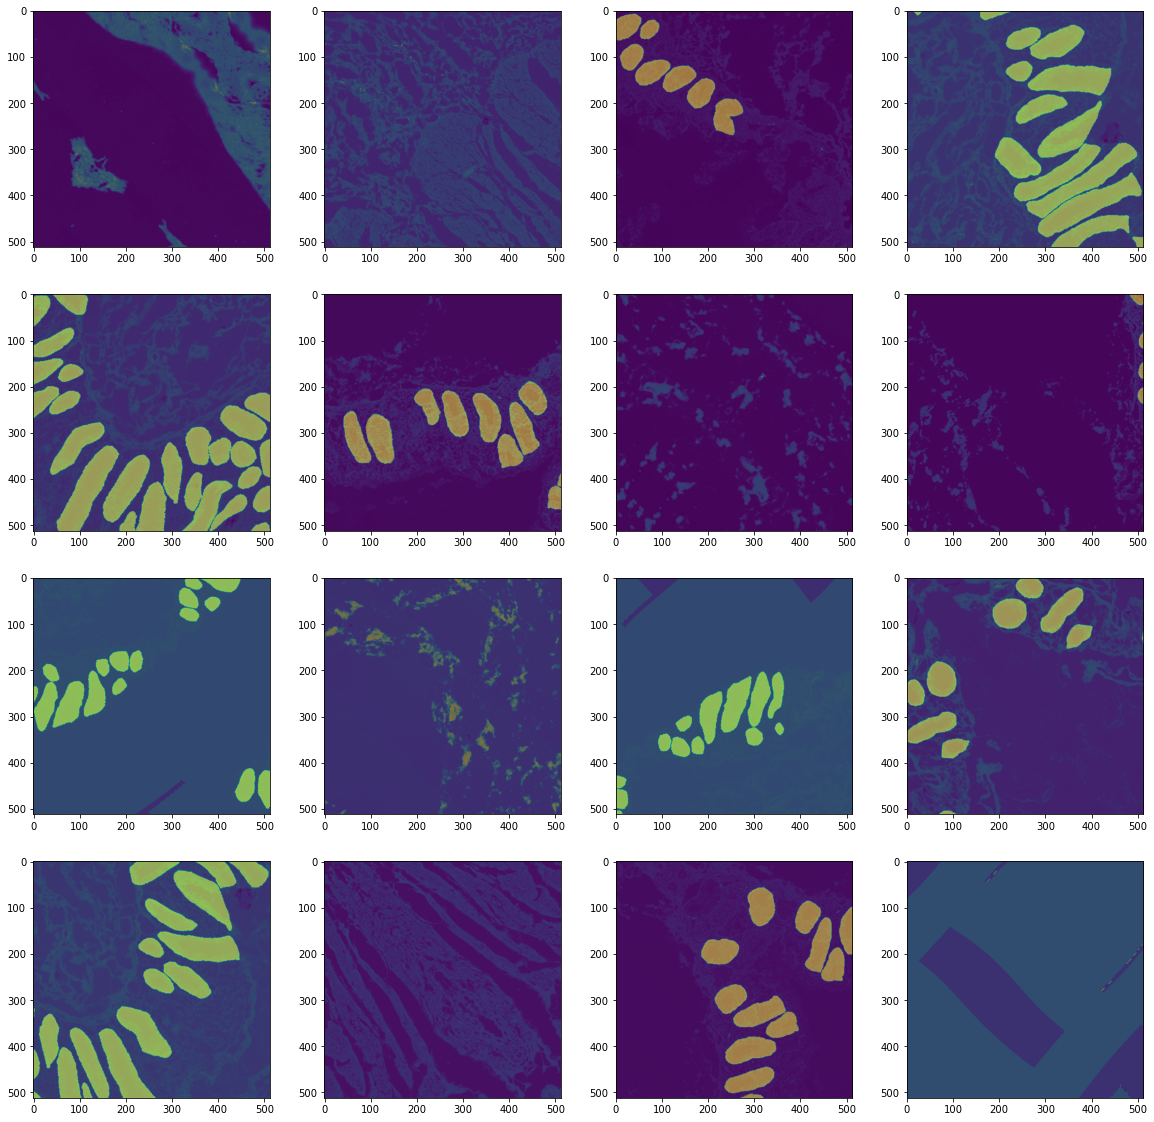

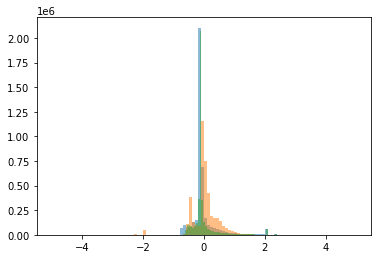

epoch,10
train_loss,0.26296
raw_loss,0.26816
wd_0,0.0
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.94999
eps_0,0.0
beta_0,0.0
_runtime,897
_timestamp,1628179127


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,███████▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
raw_loss,█████▇▆▆▆▅▅▅▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▆▅▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████


Start model fitting <fastai.learner.Learner object at 0x00000154DF1B7AF0>


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,1.933551,1.626332,0.171350,0.093703,0.503820,0.103229,02:06
1,1.718792,1.418103,0.461662,0.300105,0.965687,0.303339,02:03
2,1.372224,0.978250,0.708919,0.549090,0.870817,0.597783,02:03
3,1.059902,0.698646,0.790041,0.652949,0.843194,0.743192,01:51
4,0.790540,0.561559,0.755650,0.607264,0.694456,0.828670,01:48
5,0.586993,0.472150,0.777621,0.636154,0.754904,0.801748,01:55
6,0.431493,0.507403,0.729182,0.573789,0.657804,0.817936,01:54
7,0.336918,0.420614,0.788849,0.651322,0.766766,0.812241,01:49
8,0.282245,0.453807,0.764142,0.618309,0.712863,0.823371,01:53
9,0.251742,0.452284,0.764721,0.619067,0.715254,0.821538,02:04


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.17135038517278295.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.4616624582259602.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.70891939154936.
Generating deformation field
Generating value augmentation function
Better model found at epoch 3 with dice value: 0.7900412378574686.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function


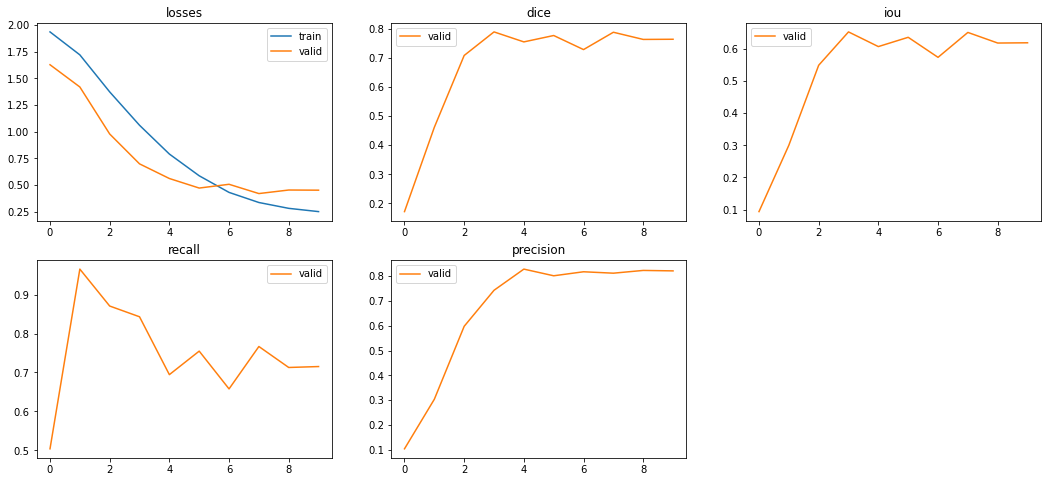

Saving Model
Model Saved
Training on ['CL_HandE_1234_B004_bottomright', 'CL_HandE_1234_B004_topleft', 'CL_HandE_1234_B004_topright', 'HandE_B005_CL_b_RGB_bottomright']
Preparing sampling
Generating deformation field
Generating value augmentation function
Calculating stats for stain normalization w/o albumentation tfms


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'CL_HandE_1234_B004_bottomright': (array([0.04160147, 0.01385395, 0.02514811]), array([0.02107909, 0.01793384, 0.01674199])), 'CL_HandE_1234_B004_topleft': (array([0.05514328, 0.01088014, 0.03863713]), array([0.11590122, 0.02770664, 0.09585546])), 'CL_HandE_1234_B004_topright': (array([0.08174399, 0.00230286, 0.04438753]), array([0.30687065, 0.05510778, 0.17676345])), 'HandE_B005_CL_b_RGB_bottomright': (array([ 0.14965684, -0.019419  ,  0.08255344]), array([0.44001847, 0.07371098, 0.25447444]))}


  0%|          | 0/12 [00:00<?, ?it/s]

{'HandE_B005_CL_b_RGB_topleft': (array([ 0.06627507, -0.00473045,  0.0363356 ]), array([0.26832575, 0.0462063 , 0.15484577]))}
Reducing validation from lenght 500 to 12
Done til here!! 
Done
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,10
train_loss,0.25174
raw_loss,0.24164
wd_0,0.0
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
_runtime,1181
_timestamp,1628181859


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,███████▇▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
raw_loss,████▇▇▆▆▅▅▄▅▅▃▃▃▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Start model fitting <fastai.learner.Learner object at 0x00000155186F8970>


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,1.769056,1.488977,0.177632,0.097473,0.771374,0.100373,02:11
1,1.472215,1.111996,0.629901,0.459749,0.934192,0.475137,02:15
2,1.042954,0.767561,0.738355,0.585232,0.707907,0.771539,02:16
3,0.712279,0.516958,0.788406,0.650718,0.789551,0.787264,02:17
4,0.487847,0.403497,0.799351,0.665766,0.766323,0.835355,02:12
5,0.352589,0.348780,0.804724,0.673254,0.747903,0.870888,02:04
6,0.265750,0.308543,0.821726,0.697398,0.798620,0.846209,02:15
7,0.221703,0.300585,0.825253,0.702495,0.794548,0.858428,02:06
8,0.190583,0.292440,0.826528,0.704345,0.796811,0.858548,02:10
9,0.179792,0.293833,0.823260,0.699610,0.783450,0.867331,02:05


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.17763221964529824.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.6299013848367635.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.7383549726972354.
Generating deformation field
Generating value augmentation function
Better model found at epoch 3 with dice value: 0.7884058197686012.
Generating deformation field
Generating value augmentation function
Better model found at epoch 4 with dice value: 0.7993513760793379.
Generating deformation field
Generating value augmentation function
Better model found at epoch 5 with dice value: 0.8047239051848356.
Generating deformation field
Generating value augmentation function
Better model found at epoch 6 with dice value: 0.8217262900035053.
Generating deformation field
Generating value augmenta

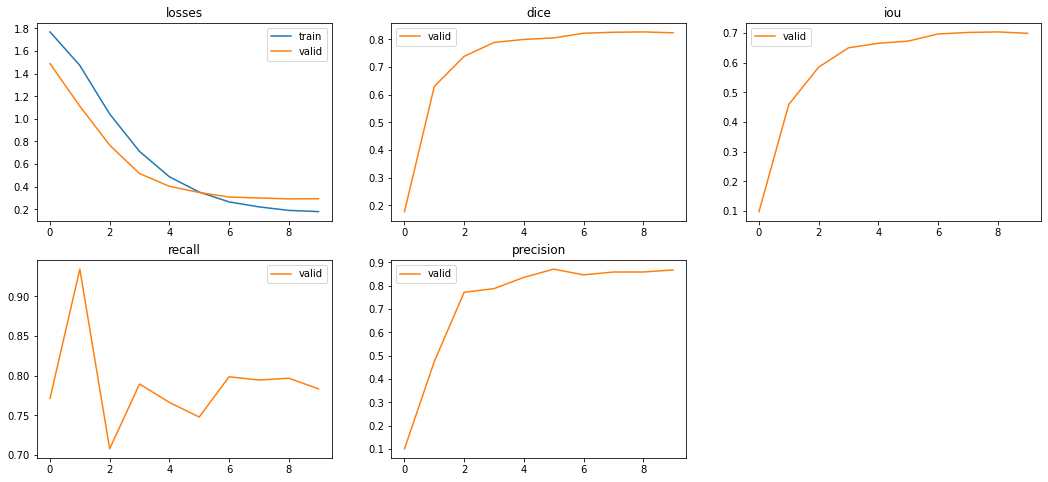

Saving Model
Model Saved
Training on ['CL_HandE_1234_B004_bottomright', 'CL_HandE_1234_B004_topleft', 'HandE_B005_CL_b_RGB_bottomright', 'HandE_B005_CL_b_RGB_topleft']
Preparing sampling
Generating deformation field
Generating value augmentation function
Calculating stats for stain normalization w/o albumentation tfms


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'CL_HandE_1234_B004_bottomright': (array([0.04210494, 0.01406237, 0.02542399]), array([0.02117594, 0.01810879, 0.01664032])), 'CL_HandE_1234_B004_topleft': (array([0.05325522, 0.01161071, 0.03785354]), array([0.09919672, 0.02629049, 0.08622227])), 'HandE_B005_CL_b_RGB_bottomright': (array([ 0.15708949, -0.02058213,  0.08689029]), array([0.4469112 , 0.07451962, 0.25822153])), 'HandE_B005_CL_b_RGB_topleft': (array([ 0.0527034 , -0.00139869,  0.02862766]), array([0.22149801, 0.03830378, 0.12789502]))}


  0%|          | 0/12 [00:00<?, ?it/s]

{'CL_HandE_1234_B004_topright': (array([ 0.11608612, -0.00410001,  0.0636907 ]), array([0.37916907, 0.06637296, 0.21838474]))}
Reducing validation from lenght 500 to 12
Done til here!! 
Done
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,10
train_loss,0.17979
raw_loss,0.16906
wd_0,0.0
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
_runtime,1328
_timestamp,1628183258


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,██████▇▇▆▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,███▇▇▇▆▅▅▄▃▃▃▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███


Start model fitting <fastai.learner.Learner object at 0x00000154DE4CF7F0>


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,1.491662,1.247088,0.017667,0.008912,0.021129,0.015180,02:18
1,1.176590,0.868963,0.604868,0.433556,0.878228,0.461287,02:01
2,0.798409,0.627942,0.681128,0.516447,0.765295,0.613639,02:08
3,0.519899,0.486520,0.701554,0.540303,0.736636,0.669661,02:06
4,0.362572,0.450177,0.704602,0.543927,0.747274,0.666539,02:10
5,0.265447,0.437971,0.695216,0.532821,0.680392,0.710701,02:10
6,0.215296,0.397637,0.731745,0.576970,0.769080,0.697867,02:07
7,0.180635,0.399853,0.729260,0.573886,0.779026,0.685470,02:03
8,0.164498,0.388185,0.737252,0.583847,0.779789,0.699115,02:12
9,0.155115,0.380859,0.745184,0.593860,0.807296,0.691948,02:04


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.017666901096611187.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.6048682107340936.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.681127877397398.
Generating deformation field
Generating value augmentation function
Better model found at epoch 3 with dice value: 0.7015538661227517.
Generating deformation field
Generating value augmentation function
Better model found at epoch 4 with dice value: 0.7046016132999953.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Better model found at epoch 6 with dice value: 0.7317449085068782.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augment

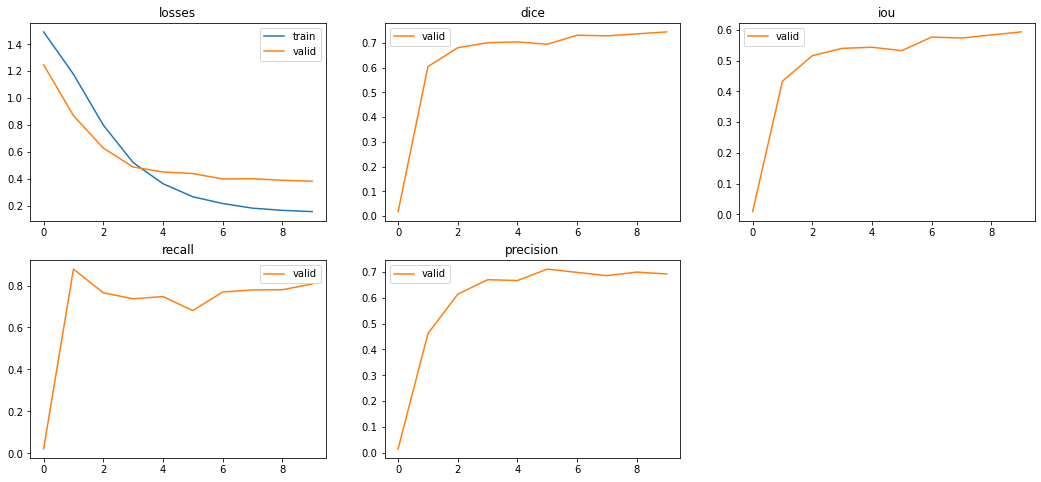

Saving Model
Model Saved
Training on ['CL_HandE_1234_B004_topleft', 'CL_HandE_1234_B004_topright', 'HandE_B005_CL_b_RGB_bottomright', 'HandE_B005_CL_b_RGB_topleft']
Preparing sampling
Generating deformation field
Generating value augmentation function
Calculating stats for stain normalization w/o albumentation tfms


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'CL_HandE_1234_B004_topleft': (array([0.05286025, 0.0118498 , 0.03706359]), array([0.08929411, 0.02500797, 0.08481781])), 'CL_HandE_1234_B004_topright': (array([0.06975795, 0.00414091, 0.03724693]), array([0.28602007, 0.05224929, 0.16466678])), 'HandE_B005_CL_b_RGB_bottomright': (array([ 0.14116138, -0.0179324 ,  0.07747258]), array([0.43215805, 0.07148264, 0.24965643])), 'HandE_B005_CL_b_RGB_topleft': (array([ 0.05646629, -0.00204744,  0.03084386]), array([0.23640551, 0.04074055, 0.1365554 ]))}


  0%|          | 0/12 [00:00<?, ?it/s]

{'CL_HandE_1234_B004_bottomright': (array([0.04359173, 0.01645749, 0.02466435]), array([0.01978748, 0.01915356, 0.0161121 ]))}
Reducing validation from lenght 500 to 12
Done til here!! 
Done
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,10
train_loss,0.15512
raw_loss,0.14886
wd_0,0.0
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
_runtime,1295
_timestamp,1628184618


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█████▇▇▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,████▇▆▆▅▃▄▃▂▂▃▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███


Start model fitting <fastai.learner.Learner object at 0x0000015518274EB0>


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,1.654297,1.827301,0.120841,0.064306,0.630228,0.066827,02:08
1,1.358582,1.235332,0.421509,0.267032,0.951818,0.270692,02:10
2,0.939582,0.565995,0.797488,0.663185,0.756103,0.843666,02:06
3,0.637532,0.389552,0.826252,0.703944,0.757299,0.909020,02:07
4,0.441179,0.308841,0.843857,0.729890,0.827202,0.861197,02:08
5,0.329745,0.277141,0.849046,0.737689,0.814034,0.887205,02:04
6,0.249504,0.258774,0.857632,0.750750,0.846558,0.869000,02:17
7,0.207905,0.281776,0.843280,0.729027,0.864343,0.823220,02:14
8,0.180535,0.278217,0.845473,0.732311,0.854616,0.836524,02:06
9,0.172770,0.303561,0.827241,0.705380,0.805566,0.850114,02:04


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.12084108755844038.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.4215085205520996.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.7974879950776474.
Generating deformation field
Generating value augmentation function
Better model found at epoch 3 with dice value: 0.8262524934564783.
Generating deformation field
Generating value augmentation function
Better model found at epoch 4 with dice value: 0.8438570011643451.
Generating deformation field
Generating value augmentation function
Better model found at epoch 5 with dice value: 0.8490458722068394.
Generating deformation field
Generating value augmentation function
Better model found at epoch 6 with dice value: 0.8576322940243122.
Generating deformation field
Generating value augmenta

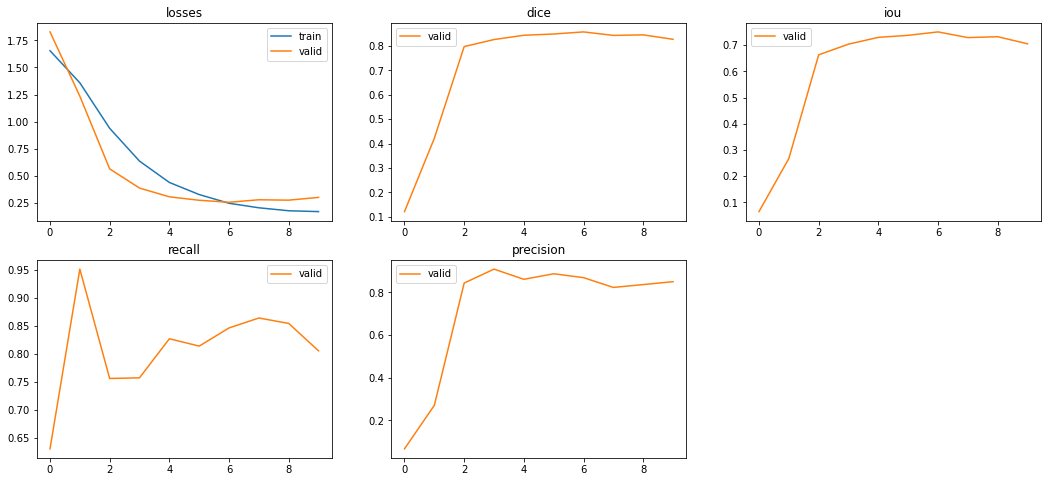

Saving Model
Model Saved
Training on ['CL_HandE_1234_B004_bottomright', 'CL_HandE_1234_B004_topleft', 'CL_HandE_1234_B004_topright', 'HandE_B005_CL_b_RGB_topleft']
Preparing sampling
Generating deformation field
Generating value augmentation function
Calculating stats for stain normalization w/o albumentation tfms


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'CL_HandE_1234_B004_bottomright': (array([0.04217442, 0.0141036 , 0.0254598 ]), array([0.02121852, 0.01813718, 0.01668336])), 'CL_HandE_1234_B004_topleft': (array([0.05328349, 0.01171581, 0.03782995]), array([0.09833417, 0.02617889, 0.08534574])), 'CL_HandE_1234_B004_topright': (array([ 0.10074209, -0.00151379,  0.05543189]), array([0.35354456, 0.06230702, 0.20365983])), 'HandE_B005_CL_b_RGB_topleft': (array([ 0.05321406, -0.00152965,  0.02894247]), array([0.22304048, 0.03854234, 0.12880648]))}


  0%|          | 0/12 [00:00<?, ?it/s]

{'HandE_B005_CL_b_RGB_bottomright': (array([ 0.27465317, -0.04119247,  0.15482251]), array([0.59877804, 0.10002655, 0.34588332]))}
Reducing validation from lenght 500 to 12
Done til here!! 
Done
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,10
train_loss,0.17277
raw_loss,0.15545
wd_0,0.0
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
_runtime,1298
_timestamp,1628185980


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█████▇▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,███▇▇▇▆▅▄▃▄▃▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Start model fitting <fastai.learner.Learner object at 0x00000154F2790AC0>


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,1.464786,1.507518,0.093700,0.049153,0.353609,0.054005,02:15
1,1.240757,1.082860,0.424060,0.269084,0.351164,0.535148,02:13
2,0.882489,0.875537,0.488278,0.322994,0.357870,0.768213,02:05
3,0.589289,0.652596,0.612153,0.441081,0.520070,0.743860,02:11
4,0.399197,0.632805,0.568471,0.397107,0.466945,0.726412,02:07
5,0.291464,0.644273,0.521091,0.352348,0.402272,0.739524,02:02
6,0.229696,0.586764,0.561205,0.390052,0.448337,0.750021,02:03
7,0.190403,0.468818,0.664315,0.497360,0.610285,0.728843,02:00
8,0.169243,0.461151,0.659064,0.491495,0.591942,0.743355,02:06
9,0.155408,0.428987,0.689831,0.526520,0.649631,0.735334,02:05


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.09370015216378234.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.4240597383023909.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.48827768890723633.
Generating deformation field
Generating value augmentation function
Better model found at epoch 3 with dice value: 0.6121531384478409.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Better model found at epoch 7 with dice value: 0.6643154637336096.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augme

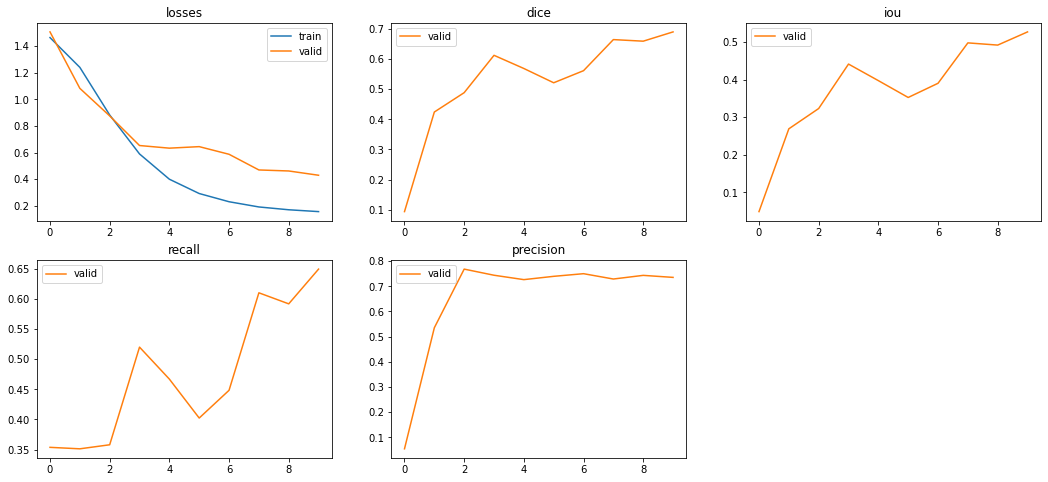

Saving Model
Model Saved


In [42]:
kf = KFold(cfg.n_splits, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(kf.split(files)):
    files_train, files_val = files[train_idx], files[val_idx]
    print('Training on', [x.name for x in files_train])
    
    # Datasets
    train_ds = HubmapRandomTileDataset(files_train, **ds_kwargs, **position_augmentation_kwargs)
    valid_ds = HubmapValidationDataset(files_val, **ds_kwargs)
    
    print ("Done til here!! ")
    
    # Model
    model = smp.Unet(encoder_name=cfg.encoder_name, 
                     encoder_weights=cfg.encoder_weights, 
                     in_channels=cfg.in_channels, 
                     classes=cfg.classes)
    print("Done")
    # Dataloader and learner
    dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=cfg.batch_size, after_batch=Normalize.from_stats(*cfg.stats))
    if torch.cuda.is_available(): dls.cuda(), model.cuda()
    
    if i==0: 
        show_batch(dls.one_batch())
        
    run = wandb.init(project='bricknet', reinit=True, config=cfg, name=f"default_with_phils_augment_{i}")

    cbs = [SaveModelCallback(monitor='dice'), ElasticDeformCallback, WandbCallback(log_preds=False, log_model=False)]
    learn = Learner(dls, model, metrics=cfg.metrics, wd=cfg.weight_decay, loss_func=cfg.loss_func, opt_func=ranger, cbs=cbs)
    if cfg.mixed_precision_training: learn.to_fp16()
    
    print ("Start model fitting", learn)
    # Fit
    learn.fit_one_cycle(cfg.epochs, lr_max=cfg.max_learning_rate)
    learn.recorder.plot_metrics()
    
    # Save Model
    print ("Saving Model")
    state = {'model': learn.model.state_dict(), 'stats':cfg.stats}
    torch.save(state, f'unet_{cfg.encoder_name}_{i}.pth', pickle_protocol=2, _use_new_zipfile_serialization=False)
    print ("Model Saved")

In [43]:
cfg.encoder_name,i

('efficientnet-b2', 4)